In [1]:
import sys
import os
from pathlib import Path

# Handling the scenario where __file__ might not be defined
if '__file__' in globals():
    # If __file__ is defined, use it to get the current directory
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
else:
    # If __file__ is not defined, fall back to the current working directory
    current_dir = Path(os.getcwd())

# Calculate the parent directory
parent_dir = current_dir.parent

# Append the parent directory to sys.path
sys.path.append(str(parent_dir))


In [2]:
import geopandas as gpd
import momepy
import networkx as nx
import igraph as ig
import pandas as pd
import matplotlib
import itertools
from shapely.geometry import LineString, point
from shapely.wkt import loads
from tqdm import tqdm
import numpy as np
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask
import math
import concurrent.futures
import matplotlib.pyplot as plt
import osmnx as ox

c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
local_crs = 27700
place = "test_OS"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [5]:
streets = gpd.read_parquet(f"../output/{place}/streets_p2.pq").to_crs(local_crs).reset_index(drop=True)
buildings = gpd.read_parquet(f"../output/{place}/buildings_p2.pq").to_crs(local_crs).reset_index(drop=True)

In [6]:
streets

geometry
0       LINESTRING (253097.270 689932.720, 253098.440 ...
1       LINESTRING (251535.000 689441.000, 251559.550 ...
2       LINESTRING (252186.460 689386.160, 252171.230 ...
3       LINESTRING (252084.000 689373.000, 252120.000 ...
4       LINESTRING (252111.980 689418.170, 252097.990 ...
...                                                   ...
248536  LINESTRING (234866.000 666794.000, 234902.570 ...
248537  LINESTRING (235105.920 666344.750, 235031.330 ...
248538  LINESTRING (235250.300 666082.800, 235182.750 ...
248539  LINESTRING (235086.010 663531.720, 235086.880 ...
248540  LINESTRING (235105.920 666344.750, 235144.800 ...

[248541 rows x 1 columns]

In [7]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

2024-01-16 19:30:09,399 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,452 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,481 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,509 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,557 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,587 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,614 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 63.92 GiB
2024-01-16 19:30:09,

<Client: 'tcp://127.0.0.1:61091' processes=8 threads=16, memory=511.38 GiB>

In [8]:
streets["id"] = streets.index

In [9]:
# Create a pandas dataframe from the multigraph
primal = momepy.gdf_to_nx(streets, approach='primal')

In [10]:
nodes, edges, sw = momepy.nx_to_gdf(primal, points=True, lines=True,
                                    spatial_weights=True)

c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 39 disconnected components.
  warnings.warn(message)


In [11]:
edges

geometry      id  \
0       LINESTRING (253097.270 689932.720, 253098.440 ...       0   
1       LINESTRING (253097.270 689932.720, 253098.440 ...   82847   
2       LINESTRING (253097.270 689932.720, 253098.440 ...  165694   
3       LINESTRING (253183.010 690116.000, 253176.010 ...       9   
4       LINESTRING (253183.010 690116.000, 253176.010 ...   82856   
...                                                   ...     ...   
248536  LINESTRING (234505.410 662292.410, 234509.040 ...  165687   
248537  LINESTRING (234505.410 662292.410, 234509.040 ...  248534   
248538  LINESTRING (235105.920 666344.750, 235031.330 ...   82843   
248539  LINESTRING (235105.920 666344.750, 235031.330 ...  165690   
248540  LINESTRING (235105.920 666344.750, 235031.330 ...  248537   

             mm_len  node_start  node_end  
0       1148.125827           0         1  
1       1148.125827           0         1  
2       1148.125827           0         1  
3        210.660925           0        11  
4        210.660925           0        11  
...             ...         ...       ...  
248536   246.069746       67637     67638  
248537   246.069746       67637     67638  
248538   208.936871       67640     67641  
248539   208.936871       67640     67641  
248540   208.936871       67640     67641  

[248541 rows x 5 columns]

In [12]:
profile = momepy.StreetProfile(edges, buildings, heights='height')
edges['widths'] = profile.w
edges['width_deviations'] = profile.wd
edges['openness'] = profile.o
edges['heights'] = profile.h
edges['heights_deviations'] = profile.hd
edges['profile'] = profile.p

NameError: name 'buildings' is not defined

In [ ]:
edges = edges.drop_duplicates(subset='geometry')

In [ ]:
nodes = nodes.drop_duplicates(subset='geometry')

In [ ]:
continuity = momepy.COINS(edges)
stroke_gdf = continuity.stroke_gdf()

In [ ]:
stroke_gdf.to_parquet(f"../output/{place}/stroke_gdf.pq")

In [ ]:
vertID_dict = {}

In [ ]:
counter = itertools.count()

for node in primal.nodes():
    id = next(counter)
    primal.nodes[node]['vertID'] = id
    vertID_dict[id] = node

In [ ]:
inverted_vertID_dict = {value: key for key, value in vertID_dict.items()}

# Street Network Shapes

In [ ]:
edg_lin = momepy.Linearity(streets)
streets['linearity'] = edg_lin.series

## Node Degree

In [ ]:
igG = ig.Graph.from_networkx(primal)
node_degrees = igG.degree(mode='all')
nodes["node_degree"] = node_degrees

In [ ]:
# # cross-testing to Momepy implementation

# degree = dict(nx.degree(primal))
# nx.set_node_attributes(primal, degree, 'degree')

# graph = momepy.node_degree(primal, name='degree')

# nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
#                                     spatial_weights=True)

# f, ax = plt.subplots(figsize=(10, 10))

# # Plot edges with a lower zorder
# edges.plot(ax=ax, color='lightgrey', zorder=1)

# # Plot nodes with a higher zorder
# nodes.plot(ax=ax, column='degree', cmap='RdYlBu', markersize=3, zorder=2)

# # Plot nodes
# scatter = ax.scatter(nodes.geometry.x, nodes.geometry.y, c=nodes['degree'], cmap='RdYlBu', s=3, zorder=2)

# # Create a legend
# legend1 = ax.legend(*scatter.legend_elements(num=5),
#                     loc="upper right", title="Node Degree")
# ax.add_artist(legend1)

# ax.set_axis_off()
# plt.show()

# node_degree["node_degree"]
# node_degree_aligned = node_degree["node_degree"].reset_index(drop=True)
# nodes_aligned = nodes["degree"].reset_index(drop=True)

# # Check if all elements are equal
# if not (node_degree_aligned == nodes_aligned).all():
#     raise ValueError("All elements in node_degree_aligned and nodes_aligned are identical.")

# Meshedness + clustering

Eucledean Dist

In [ ]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=500, name='meshedness_eucl_500', distance='mm_len')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

In [ ]:
nodes["meshedness_eucl_500"] = graph["meshedness_eucl_500"]
nodes["clustering"] = graph["clustering"]

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

Topological Distance

In [ ]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.meshedness(graph, radius=5, name='meshedness_topo_5')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

In [ ]:
nodes["meshedness_topo_5"] = graph["meshedness_topo_5"]

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column="meshedness_topo_5", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()


# Multiple Centrality Analysis

## Closeness Centrality

### Closeness centrality

Closeness centrality could be simplified as the average distance to every other node from each node. As such, it can be measured on the whole network (Global Closeness Centrality) or within a certain limit only (Local Closeness Centrality). 

#### Local closeness
To measure local `closeness_centrality` we need to specify a radius (how far we should go from each node). We can use topological distance (e.g. 5 steps, then radius=5) or metric distance (e.g. 400 metres) - then radius=400 and distance=length of each segment saved as a parameter of each edge. By default, momepy saves length as `mm_len`. 

The weight parameter is used for centrality calculation. Again, we can use metric weight (using the same attribute as above) or no weight (weight=None) at all. Or any other attribute we wish.

In [ ]:
local_closeness_clustering = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

In [ ]:
local_closeness_clustering = momepy.nx_to_gdf(local_closeness_clustering)
local_closeness_clustering = local_closeness_clustering[0]

In [ ]:
nodes["closeness_clustering_400m"] = local_closeness_clustering["closeness400"]

In [ ]:

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="closeness_clustering_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)
closeness400 = nodes["closeness_clustering_400m"]

ax.set_axis_off()
ax.set_title("closeness_clustering_400m")
plt.show()

#### Global closeness

Global closeness centrality is a bit simpler as we do not have to specify radius and distance, the rest remains the same.

In [ ]:
primal_gdf_points, primal_gdf  = momepy.nx_to_gdf(primal, points=True, lines=True)

In [ ]:
unique_ids = edges[~edges['id'].isin(primal_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in nodes where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

In [ ]:
unique_ids = nodes[~nodes['nodeID'].isin(primal_gdf_points['nodeID'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['nodeID'].tolist()

# Drop entries in edges where ID is in unique_id_list
nodes = nodes[~nodes['nodeID'].isin(unique_id_list)]

In [ ]:
closeness_centrality = igG.closeness(weights='mm_len')

# Assuming 'nodes' is your DataFrame
# Add the closeness centrality values to the DataFrame
nodes['global_closeness_centrality_primal'] = closeness_centrality


### Betweenness

Betweenness centrality measures the importance of each node or edge for travelling along the network. It measures how many times each node/edge used if we walk using the shortest paths from each node to every other. 

We have two options of how to measure betweenness on primal graphs - on nodes or on edges.

#### Node-based
Node-based betweenness, as the name suggests, measures the betweenness of each node - how many times we would walk through the node.

In [ ]:

# Compute betweenness centrality (vertex betweenness only in this case)
vertex_betweenness = igG.betweenness(weights="mm_len")

# Assuming 'nodes' is a DataFrame that should include the vertex betweenness centrality
nodes['global_betweeness_centrality_vertex'] = vertex_betweenness


TypeError: 'edges' is an invalid keyword argument for this function

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 13.
  warnings.warn(


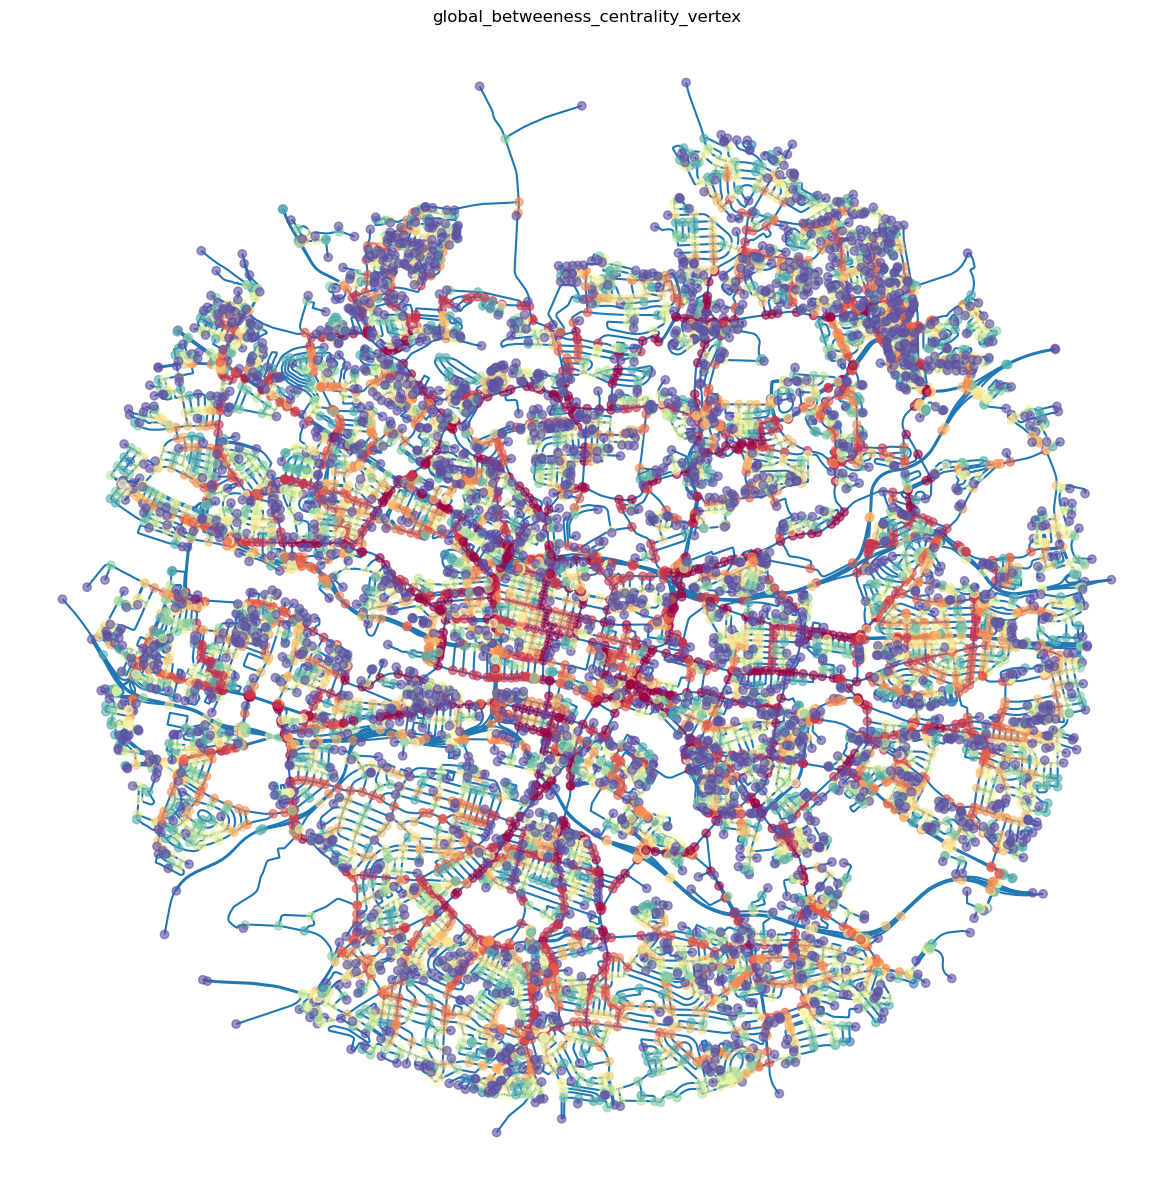

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)

ax.set_axis_off()
ax.set_title(label='global_betweeness_centrality_vertex')
plt.show()

#### Edge-based

Edge-based betweenness does the same but for edges: how many times we go through each edge (street).

In [ ]:

# Compute betweenness centrality (vertex betweenness only in this case)
edge_betweenness = igG.edge_betweenness(weights="mm_len")

# Assuming 'nodes' is a DataFrame that should include the vertex betweenness centrality
edges['betweeness_centrality_edge'] = edge_betweenness


/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 13.
  warnings.warn(


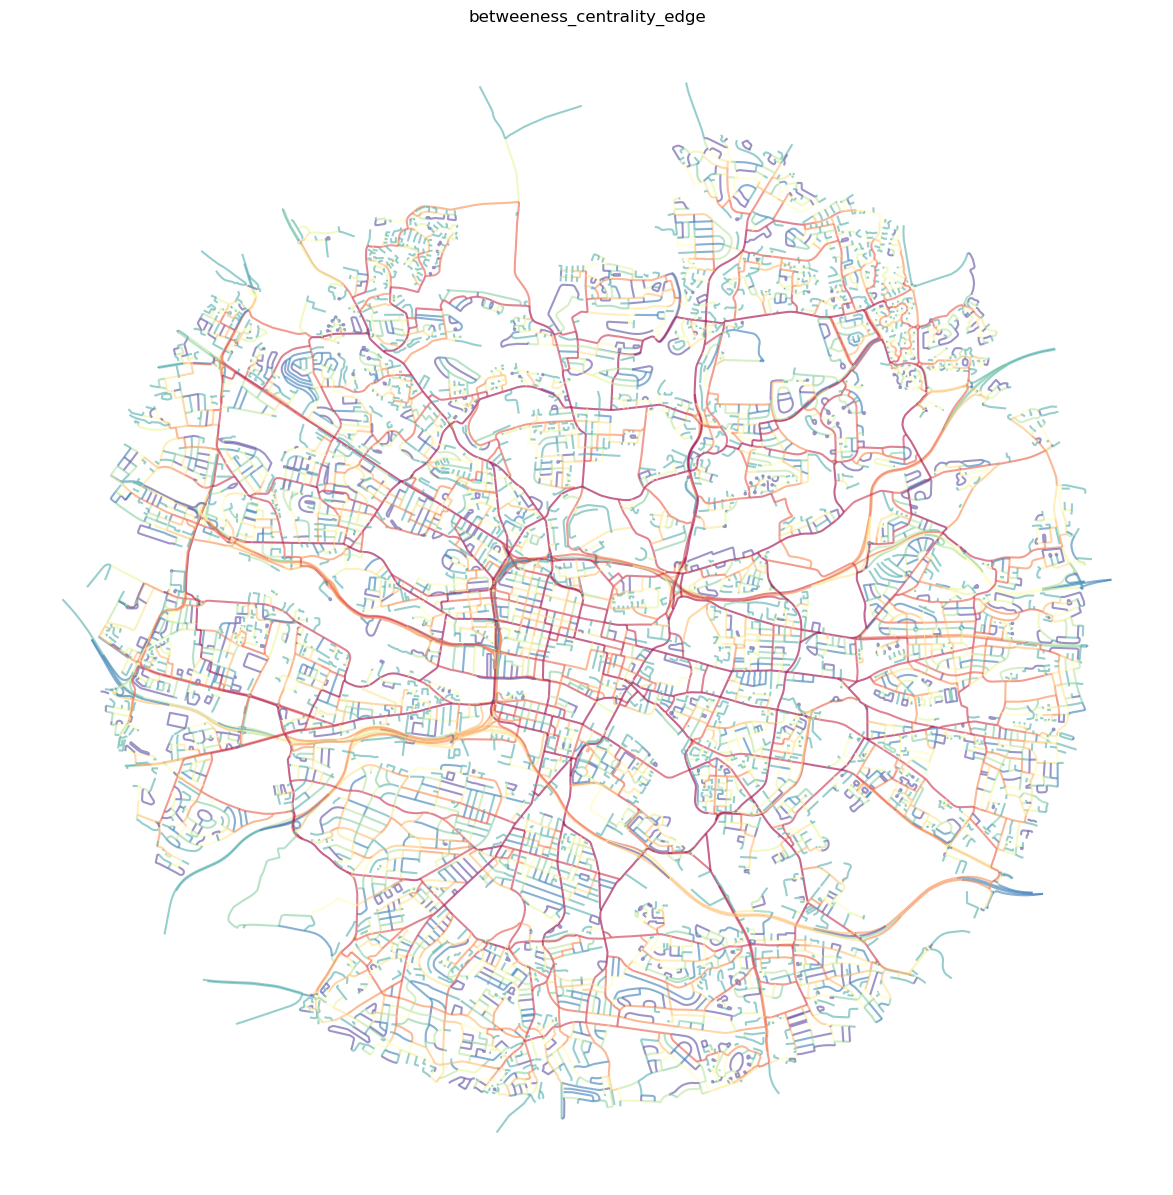

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column='betweeness_centrality_edge', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)

ax.set_axis_off()
ax.set_title(label='betweeness_centrality_edge')
plt.show()

### Straightness

While both closeness and betweenness are generally used in many applications of network analysis, straightness centrality is specific to street networks as it requires a geographical element. It is measured as a ratio between real and Euclidean distance while waking from each node to every other.

In [ ]:
primal = momepy.straightness_centrality(primal, weight='mm_len', radius=5)
gdf = momepy.nx_to_gdf(primal, lines=False)

  0%|          | 51/11587 [00:02<08:27, 22.71it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/virgilxw/miniforge3/envs/processor_nb/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2913/144078398.py", line 1, in <module>
    primal = momepy.straightness_centrality(primal, weight='mm_len', radius=5)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/virgilxw/miniforge3/envs/processor_nb/lib/python3.11/site-packages/momepy/graph.py", line 981, in straightness_centrality
    netx.nodes[n][name] = _straightness_centrality(
                          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/virgilxw/miniforge3/envs/processor_nb/lib/python3.11/site-packages/momepy/graph.py", line 906, in _straightness_centrality
    sp = nx.single_source_dijkstra_path_length(graph, n, weight=weight)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/virgilxw/minifor

In [ ]:
nodes["global_straightness_centrality"] = gdf["straightness"]

In [ ]:


nodes["straightness_400m"] = gdf["straightness"]

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="straightness_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)

ax.set_axis_off()
ax.set_title("global_straightness_centrality")
plt.show()

### Node values averaged onto edges

In some cases, it is easier to understand centrality results if they are attached to street segments, rather than intersections. We can do an approximation using the mean value attached to start and end node of each edge.

In [ ]:
nodes

In [ ]:
for node in primal.nodes:
    row = nodes[nodes["nodeID"] == primal.nodes[node]["nodeID"]].iloc[0]
    
    columns = row.keys().drop(['nodeID', 'geometry'])
    for column in columns:
        primal.nodes[node][column] = row[column]

In [ ]:
primal.nodes

In [ ]:
momepy.mean_nodes(primal, 'global_straightness_centrality')
momepy.mean_nodes(primal, 'closeness_clustering_400m')
momepy.mean_nodes(primal, 'global_closeness_centrality_primal')
momepy.mean_nodes(primal, 'global_betweeness_centrality_vertex')

In [ ]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_straightness_centrality', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness_clustering_400m', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400 node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_closeness_centrality_primal', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness global node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes node based mean')
plt.show()

In [ ]:
edges["global_straightness_centrality"] = primal_gdf["global_straightness_centrality"]
edges["closeness_clustering_400m"] = primal_gdf["closeness_clustering_400m"]
edges["global_closeness_centrality_primal	"] = primal_gdf["global_closeness_centrality_primal"]
edges["global_betweeness_centrality_vertex"] = primal_gdf["global_betweeness_centrality_vertex"]

In [ ]:
edges

Once we have finished our network analysis on the primal graph, we can save both nodes and edges back to GeoDataFrames.

### Topological vs metric distances

Centrality can be measured topologically (ignoring physical lengths of street segments) or metrically. Moreover, in the case of local centrality, local subgraphs can be also defined topologically and metrically. In the end, you have four options of how to measure centralilty, illustrated on `betweenness_centrality`:

```py
# topologically defined subgraph (5 steps) and topologically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight=None)

# topologically defined subgraph (5 steps) and metrically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight='edge_length')

# metrically defined subgraph (800 meters) and topologically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight=None)

# metrically defined subgraph (800 meters) and metrically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight='edge_length')
```

## Dual graph

Dual graph is a bit more complicated concept as it represents street segments as nodes with intersections as edges connecting nodes. The geographical distance is lost as edges are of virtually no length, but we can capture the angle between connected streets. Momepy does that by default, using angles between lines connecting the start and end points of each segment. Hence, we can measure angular centrality.

**Note**: Dual graphs have naturally much more connections than primal ones, so computation of centrality on dual graph takes longer.

In [ ]:
edges["id"] = edges.index

In [ ]:
dual = momepy.gdf_to_nx(edges, approach='dual')

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)


In [ ]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
dual_gdf

geometry     id      mm_len  \
0      LINESTRING (254595.109 664390.697, 254660.836 ...      0  261.113120   
1      LINESTRING (254595.109 664390.697, 254660.232 ...      1  768.188834   
2      LINESTRING (253684.000 664697.747, 253722.925 ...      2  970.830386   
3      LINESTRING (254849.562 664336.774, 254873.037 ...      3   45.906934   
4      LINESTRING (254849.562 664336.774, 254876.557 ...      4   41.341029   
...                                                  ...    ...         ...   
15137  LINESTRING (257112.975 665605.203, 257111.728 ...  15129    5.841132   
15138  LINESTRING (257116.918 665624.043, 257112.975 ...  15131   19.247271   
15139  LINESTRING (257105.142 665606.810, 257112.975 ...  15132    7.996575   
15140  LINESTRING (257109.506 665625.713, 257116.918 ...  15133    7.597626   
15141  LINESTRING (257113.352 665644.099, 257120.775 ...  15134   26.523432   

       node_start  node_end  betweeness_centrality_edge  
0               0         1                     32379.0  
1               0         2                      6095.0  
2               0         3                     30708.0  
3               1         4                      2696.0  
4               1         5                     41231.0  
...           ...       ...                         ...  
15137       11577     11579                     57780.0  
15138       11579     11581                     34674.0  
15139       11579     11582                     11560.0  
15140       11581     11583                     11560.0  
15141       11581     11584                     11560.0  

[15142 rows x 6 columns]

In [ ]:
unique_ids = edges[~edges['id'].isin(dual_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in edges where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

### Angular closeness

The situation with closeness is similar to the one done on primal graphs. We can again do global and local closeness.

#### Local
The difference is that we do not have geographic distance, so we can limit closeness topologically or by another attribute (line angle). The example below uses a topological distance of 5 steps.

In [ ]:
closeness_dual = momepy.closeness_centrality(dual, radius=5, name='angular_closeness_order_5', weight='angle')

dual_gdf = momepy.nx_to_gdf(closeness_dual, points=False)


In [ ]:
edges['angular_closeness_order_5'] = dual_gdf['angular_closeness_order_5']

f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angular_closeness_order_5', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular 5')
plt.show()

#### Global

Global angular closeness is then straightforward.

In [ ]:
igG = ig.Graph.from_networkx(dual)

In [ ]:
# Compute closeness centrality
# Note: The weights parameter expects the name of the edge attribute
closeness_centrality = igG.closeness(weights="angle")

# The closeness_centrality is already an array of values corresponding to each vertex
edges['global_angular_closeness'] = closeness_centrality

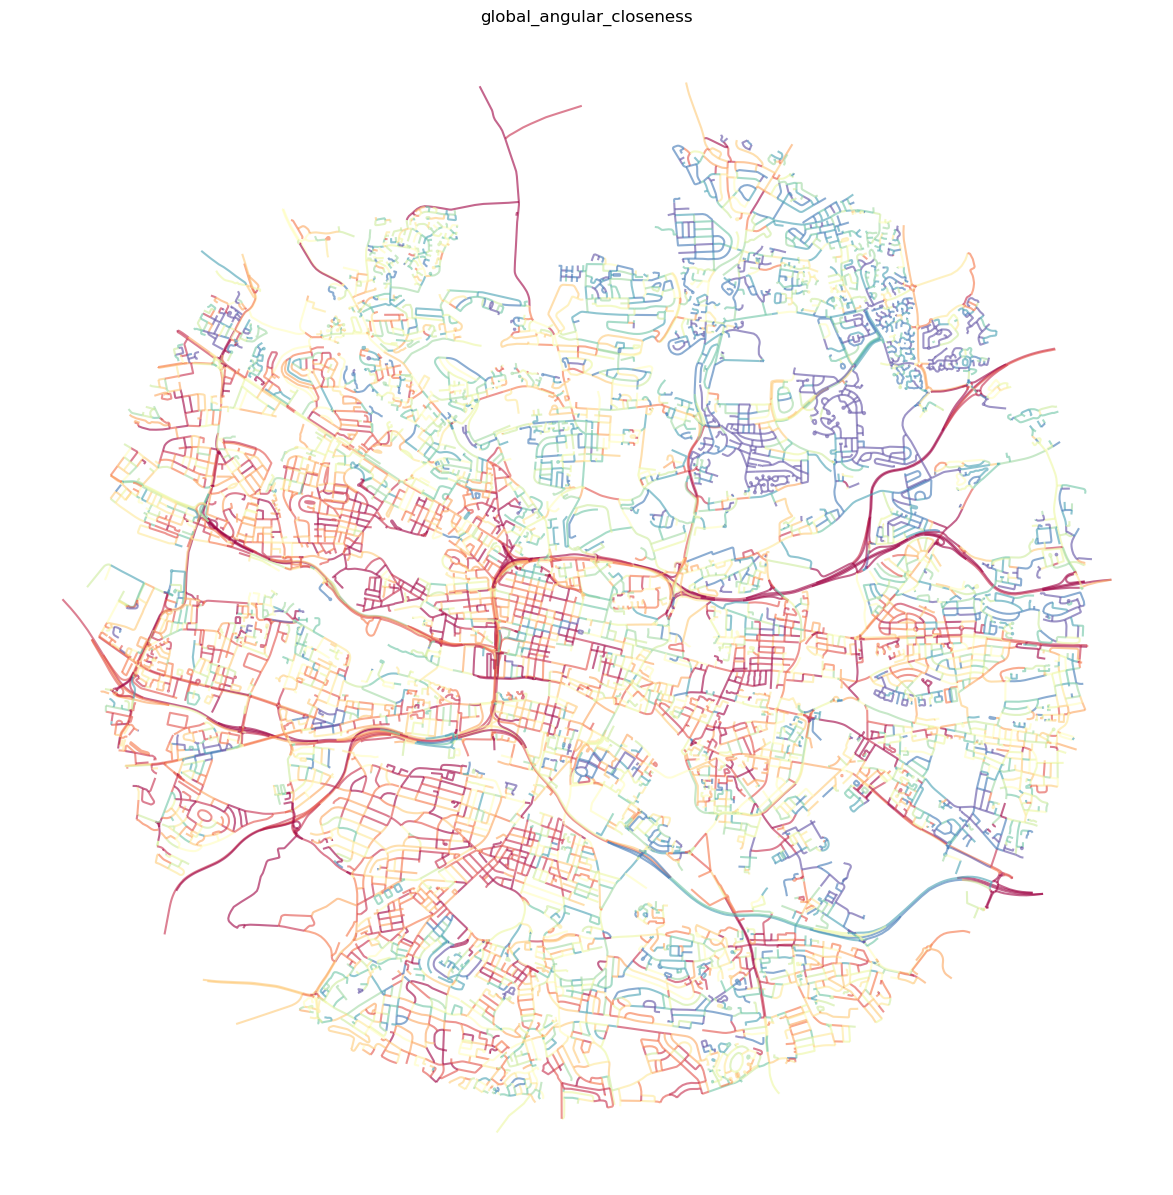

In [ ]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column='global_angular_closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('global_angular_closeness')
plt.show()

### Angular betweenness
The last option momepy offers is angular betweenness. Just keep in mind, that nodes and edges are not representing the same concepts and it does not make much sense to measure angular betweenness on edges. Moreover, `nx_to_gdf` converts a dual graph to a LineString gdf only.

In [ ]:
edge_betweenness = igG.betweenness(weights="angle")

# Assuming 'edges_df' is a DataFrame representing the edges of the graph
# Add the edge betweenness centrality values to the DataFrame
# Ensure that the DataFrame 'edges_df' is in the same order as the edges in 'igG'
edges['global_angular_betweeness'] = edge_betweenness


/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 14.
  warnings.warn(


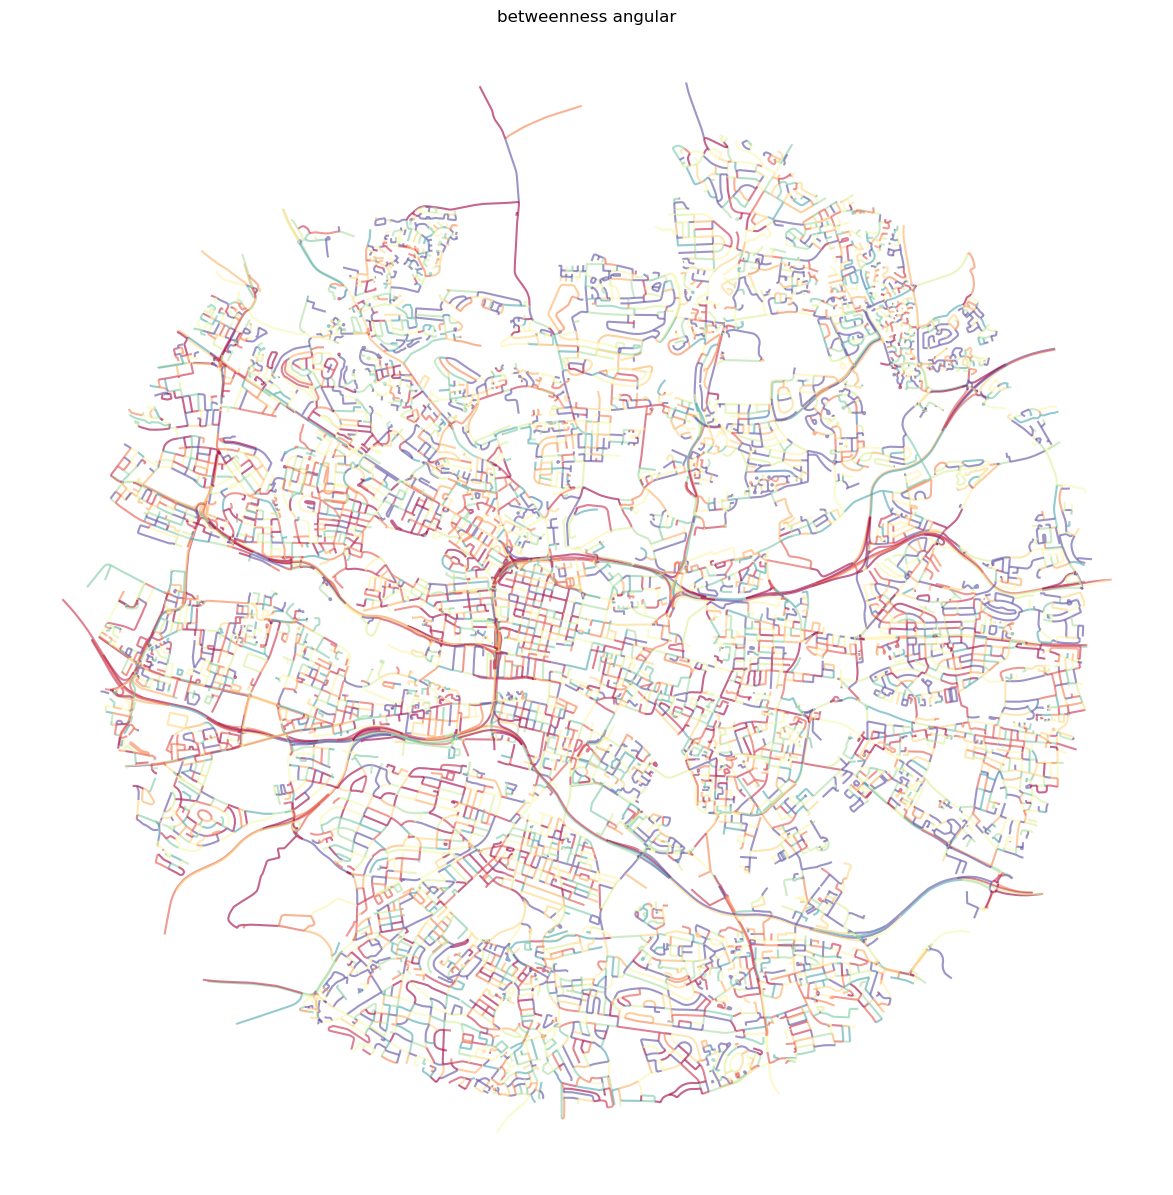

In [ ]:
df, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column="global_angular_betweeness", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness angular')
plt.show()

In [ ]:
edges = edges.drop(columns=["id"], axis=1)

In [ ]:
nodes

nodeID                       geometry  node_degree  \
0           0  POINT (254595.109 664390.697)            3   
1           1  POINT (254849.562 664336.774)            3   
2           2  POINT (255338.105 664211.361)            3   
3           3  POINT (253684.000 664697.747)            3   
4           4  POINT (254893.239 664347.673)            3   
...       ...                            ...          ...   
11582   11582  POINT (257105.142 665606.810)            1   
11583   11583  POINT (257109.506 665625.713)            1   
11584   11584  POINT (257113.352 665644.099)            1   
11585   11585  POINT (259902.956 669716.906)            3   
11586   11586  POINT (259995.425 669715.044)            3   

       global_closeness_centrality_primal  \
0                                0.000135   
1                                0.000140   
2                                0.000144   
3                                0.000126   
4                                0.000141   
...                                   ...   
11582                            0.000184   
11583                            0.000183   
11584                            0.000183   
11585                            0.000137   
11586                            0.000135   

       global_betweeness_centrality_vertex  betweeness_centrality_edge  
0                                  28811.0                    0.000135  
1                                  32373.0                    0.000140  
2                                  28010.0                    0.000144  
3                                  23028.0                    0.000126  
4                                 444937.0                    0.000141  
...                                    ...                         ...  
11582                                  0.0                    0.000184  
11583                                  0.0                    0.000183  
11584                                  0.0                    0.000183  
11585                              11559.0                    0.000137  
11586                                  0.0                    0.000135  

[11587 rows x 6 columns]

In [ ]:
edges.to_parquet(f"../output/{place}/edges_p4.pq")
nodes.to_parquet(f"../output/{place}/nodes_p4.pq")